# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


## Lab. 04 - Text generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import functools
from pathlib import Path
from tqdm.notebook import tqdm

# Download dataset

Each sonnet will be stored in the `shakespeare_sonnets` folder as a separate `txt` file.

In [2]:
import requests # library to easily send HTTP/1.1 requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup # library for pulling data out of HTML and XML files.

base_url = "http://shakespeare.mit.edu/Poetry/"
base_dataset_dir = 'shakespeare_sonnets'

## Get page with sonnet list
res = requests.get(urljoin(base_url, "sonnets.html"))
assert res.status_code == 200  # status_code=200 if successful event

## Get all sonnet links
soup = BeautifulSoup(res.text)
all_links = [link.get('href') for link in soup.find_all('a')]
all_links = [link for link in all_links if link.startswith('sonnet')]

## Download each sonnet
for link in tqdm(all_links):
  # Get web page with the sonnet
  res = requests.get(urljoin(base_url, link))
  assert res.status_code == 200
  # Convert to proper text
  soup = BeautifulSoup(res.text)
  sonnet_text = soup.find('blockquote').get_text()
  # Save file
  sonnet_file = Path(base_dataset_dir) / link.replace('html', 'txt')
  sonnet_file.parent.mkdir(exist_ok=True, parents=True) # Create parent dir, if required
  with open(sonnet_file, 'w') as f:
    f.write(sonnet_text)

  0%|          | 0/154 [00:00<?, ?it/s]

# Data processing

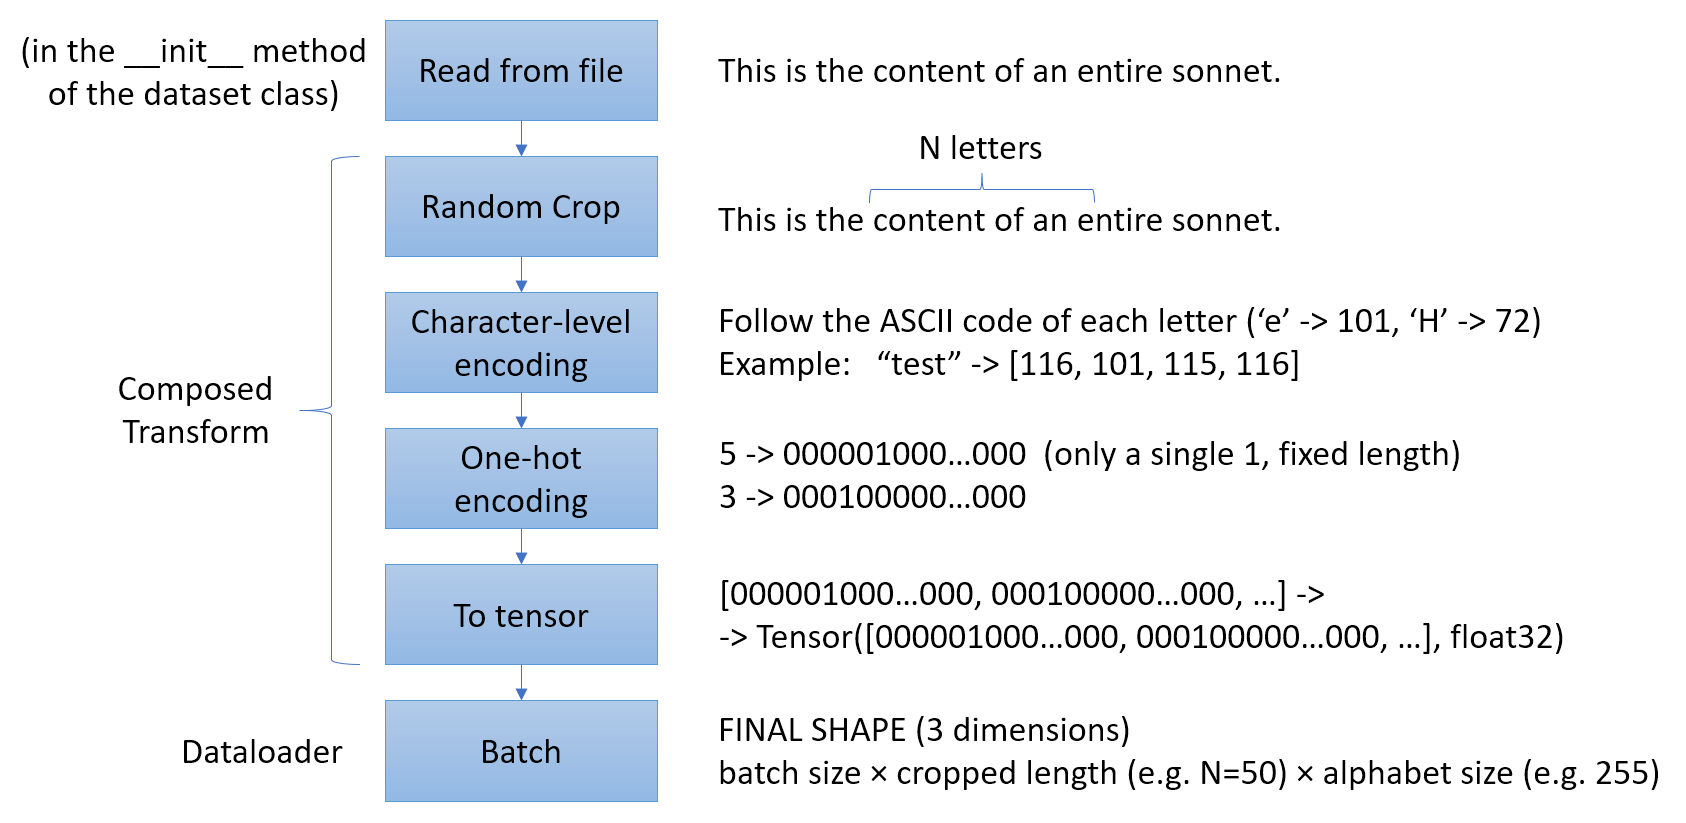

Notes: 

* Random crop: data augmentation for better generalization (it reduces overfitting). NB: the order of the letters is important!
*   Read files in the __init__ metod for simplicity. This dataset fits into memory, so it is much faster.
*   One single character is encoded to a different word in our code (differently from word-level encoding). We use ASCII table: 255 characters in total. Then we can use 
*  Each encoded character (numerical value) is one-hot encoded (binary vector, only one 1 at the index): fixed lenght of 255

Final remark: encoding is not done in the __init__ method because extremely fast and typically is performed as part of the transforms.

### (Optional) Homework
We use only a subset of letters in our dataset. So the input will have always zeros at certain indices. This causes problems to our network training. Therefore, we could build a custom mapping avoiding to encode symbols that are never used in our dataset (i.e., reduce the fixed length to < 255).

## Dataset definition

In [3]:
class ShakespeareDataset(Dataset):
    
    def __init__(self, dataset_dir, transform=None):

        # Convert the dataset_dir to a Path object (it has very useful methods)
        dataset_dir = Path(dataset_dir)

        ### Load sonnet from each txt file in dataset_dir
        self.sonnet_list = []
        for sonnet_file in dataset_dir.iterdir():
          # Open file and read the content 
          with open(sonnet_file, 'r') as f:
            sonnet_text = f.read()
          # (Optional) Remove any leading and trailing whitespaces from each line
          sonnet_text = '\n'.join([t.strip() for t in sonnet_text.splitlines()])
          # (Optional) Convert all letters to lowercase: it reduces dimensionality of the dataset
          sonnet_text = sonnet_text.lower()
          # Append the sonnet text to the sonnet list
          self.sonnet_list.append(sonnet_text)

        ### Save the transformation
        self.transform = transform
        
    def __len__(self):
        return len(self.sonnet_list)
        
    def __getitem__(self, idx):
        # Get sonnet text
        sample = self.sonnet_list[idx]
        # Transform (if defined)
        if self.transform:
            sample = self.transform(sample)
        return sample

### Test if it works
dataset_dir = 'shakespeare_sonnets'
dataset = ShakespeareDataset(dataset_dir)

index = 1
print(f"\nSONNET AT INDEX {index}")
print(dataset[index])


SONNET AT INDEX 1
when, in disgrace with fortune and men's eyes,
i all alone beweep my outcast state
and trouble deaf heaven with my bootless cries
and look upon myself and curse my fate,
wishing me like to one more rich in hope,
featured like him, like him with friends possess'd,
desiring this man's art and that man's scope,
with what i most enjoy contented least;
yet in these thoughts myself almost despising,
haply i think on thee, and then my state,
like to the lark at break of day arising
from sullen earth, sings hymns at heaven's gate;
for thy sweet love remember'd such wealth brings
that then i scorn to change my state with kings.


## Data transormation

### Random crop

In [4]:
class RandomCrop():
    """
    Choose a random substring (encoded) of length "crop_len" from "sample"
    """
    def __init__(self, crop_len):
        self.crop_len = crop_len
        
    def __call__(self, sample):
        tot_chars = len(sample)
        # Do not crop if sample is shorter than crop_len
        if tot_chars <= self.crop_len:
          return sample
        # Randomly choose an index inside a valid range
        start_idx = np.random.randint(0, tot_chars - self.crop_len)
        end_idx = start_idx + self.crop_len
        # Crop the sample
        return sample[start_idx: end_idx]
        
### Test if it works
random_crop = RandomCrop(crop_len=30)
cropped_sample = random_crop(dataset[0])
print("CROPPED SAMPLE")
print(cropped_sample)

CROPPED SAMPLE
h too much rage,
whose strengt


### Character-level encoder

The `ord` and `chr` functions simply convert a character to the corresponding ASCII code, and viceversa.

Double check with: https://www.asciitable.com/


In [5]:
class EncodeText():
  """
  Convert each character in "text" in the corresponding ASCII code (from 0 to 255) 
  and return a list of the encodings.
    INPUT
      text: e.g. "test"
    OUTPUT
      encoded_text: e.g. [116, 101, 115, 116]
  """
  def __call__(self, text):
    encoded_text = [ord(c) for c in text]
    return encoded_text

### Test if it works
encode_text = EncodeText()
encoded_text = encode_text("test")
print(encoded_text)

[116, 101, 115, 116]


In [6]:
class DecodeText():
  """
  From a list of encoded characters (list of values from 0 to 255), convert the 
  ASCII code to the corresponding letter and return a single string.
    INPUT
      encoded_text: e.g. [116, 101, 115, 116]
    OUTPUT
      decoded_text: e.g. "test"
  """
  def __call__(self, encoded_text):
    decoded_text = ''.join([chr(c) for c in encoded_text]) # Convert each ASCII code to the corresponding letter #TODO
    decoded_text = functools.reduce(lambda x, y: x + y, decoded_text)
    return decoded_text

### Test if it works
decode_text = DecodeText()
decoded_text = decode_text(encoded_text)
print(decoded_text)

test


### One-hot encoder

In [7]:
class OneHotEncoder():
    """
    Convert each encoded character in "sample" in a one-hot representation.
    INPUT
      e.g. 7
    OUTPUT
      0000001000 # all zeros but 1 at position 7.
    """
    
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample):

        ### Create one hot matrix
        # (hint: try to avoid for loops -> huge speed-up)
        onehot = np.zeros([len(sample), self.alphabet_len])
        tot_chars = len(sample)
        onehot[np.arange(tot_chars), sample] = 1

        return onehot
        
### Test if it works
one_hot_encoder = OneHotEncoder(10) # the lenght will be 255 in our real case!
test_sample = [1,5,6,3,2]
onehot = one_hot_encoder(test_sample)
print(onehot)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


### To tensor

In [8]:
class ToTensor():
  """
  Convert one hot encoded text to pytorch tensor
  """
  def __call__(self, sample):
    return torch.tensor(sample).float()
      
### Test if it works
to_tensor = ToTensor()
tensor = to_tensor(onehot)
print(tensor)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


### Composed transform

In [9]:
crop_len = 50
alphabet_len = 255

### Define the preprocessing pipeline
# Random crop -> Character Encoding ->  One-hot encoding -> To tensor
transform = transforms.Compose([RandomCrop(crop_len), EncodeText(), OneHotEncoder(alphabet_len), ToTensor()])

### Test all the chain
transformed_sample = transform(dataset[0])
print(transformed_sample)
print(transformed_sample.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([50, 255])


### Dataloader

In [10]:
### Redefine the dataset with the composed transofrmation
dataset_dir = 'shakespeare_sonnets'
dataset = ShakespeareDataset(dataset_dir, transform=transform)
### Define the dataloader to enable batching and shuffling
dataloader = DataLoader(dataset, batch_size=52, shuffle=True)
# Test dataloader output
batch_sample = next(iter(dataloader))
print(batch_sample.shape)
print(len(dataset))  
# if batch_size = 52. Lenght of batches: 52, 52, 50
# if batch_size = 50. Lenght of batches: 50, 50, 50, 4 [better to have comparable sizes...]

torch.Size([52, 50, 255])
154


# Network

We use LSTM layers. Multi-class classification problem to infer the next letter in the sonnet.

Softmax: goes from the linear output to the probability distribution over the classes.

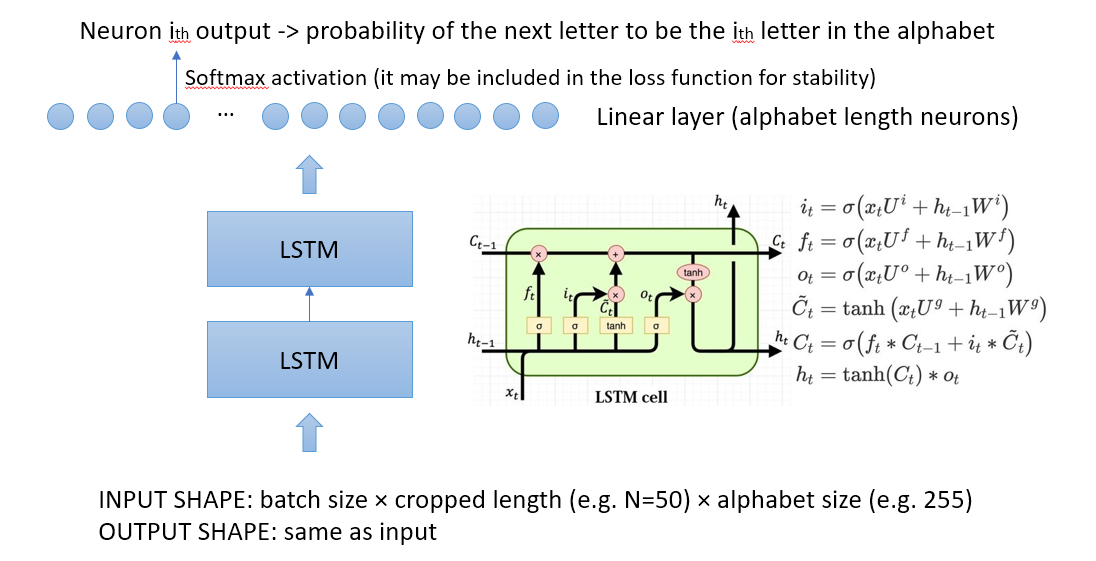

LSTM layer doc: [https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [12]:
class Network(nn.Module):
    
    def __init__(self, input_size, hidden_units, layers_num, dropout_prob=0):
        # Call the parent init function (required!)
        super().__init__()
        # Define recurrent layers
        self.rnn = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_units,
                           num_layers=layers_num,
                           dropout=dropout_prob,
                           batch_first= True # TODO: True or False? # NOTE carefully
                           ) 
        # Define output layer (useful for flexibility and transfer learning)
        self.out = nn.Linear(hidden_units, input_size)
        
    def forward(self, x, state=None):
        # LSTM
        x, rnn_state = self.rnn(x, state)
        # Linear layer
        x = self.out(x)
        # Remember to return also the RNN state, you will need it to generate data
        return x, rnn_state

In [13]:
# Define network
input_size = 255
hidden_units = 128
layers_num = 2
dropout_prob = 0.3
net = Network(input_size, hidden_units, layers_num, dropout_prob)

In [14]:
# Test network with one batch
batch_sample = next(iter(dataloader))
    
#%% Test the network output
out, rnn_state = net(batch_sample)
print(f"Out shape: \t\t{out.shape}")
print(f"Hidden state shape: \t{rnn_state[0].shape}")
print(f"Cell state shape: \t{rnn_state[1].shape}")

Out shape: 		torch.Size([52, 50, 255])
Hidden state shape: 	torch.Size([2, 52, 128])
Cell state shape: 	torch.Size([2, 52, 128])


# Train

Labels are just the inputs shifted by one character.

INPUT | LABEL | |
--- | --- | ---
t | h | (NOTE: the actual input and label are a one-hot representation of the letters)
h | i |
i | s |
s |   |
  | i |
i | s |
s |   |
  | a |
a | n |
n |   |
  | e |
e | x | 
x | a |
a | m |
m | p |
p | l | 
l | e |
~~e~~ | | (the last input has no label, to be removed)

## Loss and optimizer

Suggested loss: `CrossEntropyLoss` [https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

Depending on how you developed the network, you may need to adapt the shape of your tensors to match the required shape (in the training loop). You can use the `.permute()` method of the tensor object to easily swap the axis order ([check the documentation](https://pytorch.org/docs/stable/tensors.html)).

This are the shapes of the input and the labels required by the `CrossEntropyLoss`, as you can see from the documentation page:

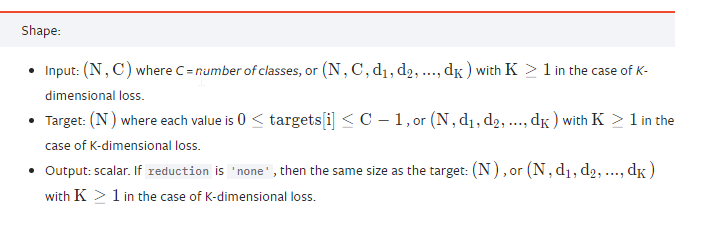

In [15]:
# Define the optimizer
optimizer = torch.optim.RMSprop(net.parameters())

# Define the loss function
loss_fn = nn.CrossEntropyLoss()  # it already applies softmax

## Training loop

In [16]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net.train()

### Iterate through the dataloader for "num_epochs"
num_epochs = 1000
for num_epoch in tqdm(range(num_epochs)):
  epoch_losses = []
  for batch_sample in dataloader:

    ### Move samples to the proper device
    batch_sample = batch_sample.to(device)

    ### Prepare network input and labels
    net_input  = batch_sample[:, :-1, :]
    labels = batch_sample[:, 1:, :]

    ### Forward pass
    # Clear previous recorded gradients
    optimizer.zero_grad()
    # Forward pass
    net_out, _ = net(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"

    ### Update network
    # Evaluate loss (pay attention to the proper tensor shapes)
    labels = labels.argmax(dim=-1)
    net_out = net_out.permute([0,2,1])
    loss = loss_fn(net_out, labels)
    # Backward pass
    loss.backward()
    # Update
    optimizer.step()
    # Save batch loss
    epoch_losses.append(loss.data.cpu().numpy())
  # Print average epoch loss
  print(f"Epoch {num_epoch + 1} loss: {np.mean(epoch_losses)}")

Training device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1 loss: 5.84553861618042
Epoch 2 loss: 4.932189464569092
Epoch 3 loss: 3.108269453048706
Epoch 4 loss: 3.032419443130493
Epoch 5 loss: 3.0227115154266357
Epoch 6 loss: 3.0154078006744385
Epoch 7 loss: 3.0241057872772217
Epoch 8 loss: 3.008491277694702
Epoch 9 loss: 3.015692949295044
Epoch 10 loss: 2.9975993633270264
Epoch 11 loss: 3.0098989009857178
Epoch 12 loss: 3.001600980758667
Epoch 13 loss: 3.001582384109497
Epoch 14 loss: 3.019953966140747
Epoch 15 loss: 2.9941608905792236
Epoch 16 loss: 2.990248680114746
Epoch 17 loss: 3.007134199142456
Epoch 18 loss: 3.0100910663604736
Epoch 19 loss: 3.018824815750122
Epoch 20 loss: 3.0136985778808594
Epoch 21 loss: 3.0096967220306396
Epoch 22 loss: 3.008012056350708
Epoch 23 loss: 2.989614486694336
Epoch 24 loss: 3.002432107925415
Epoch 25 loss: 3.003591299057007
Epoch 26 loss: 3.0064821243286133
Epoch 27 loss: 3.0066518783569336
Epoch 28 loss: 2.9973576068878174
Epoch 29 loss: 3.0136051177978516
Epoch 30 loss: 3.0020649433135986
Epoch 

# Generate Sonnet

Run inference. Two choices: 

*   Start from a random letter
*   Start from a starting string (seed)


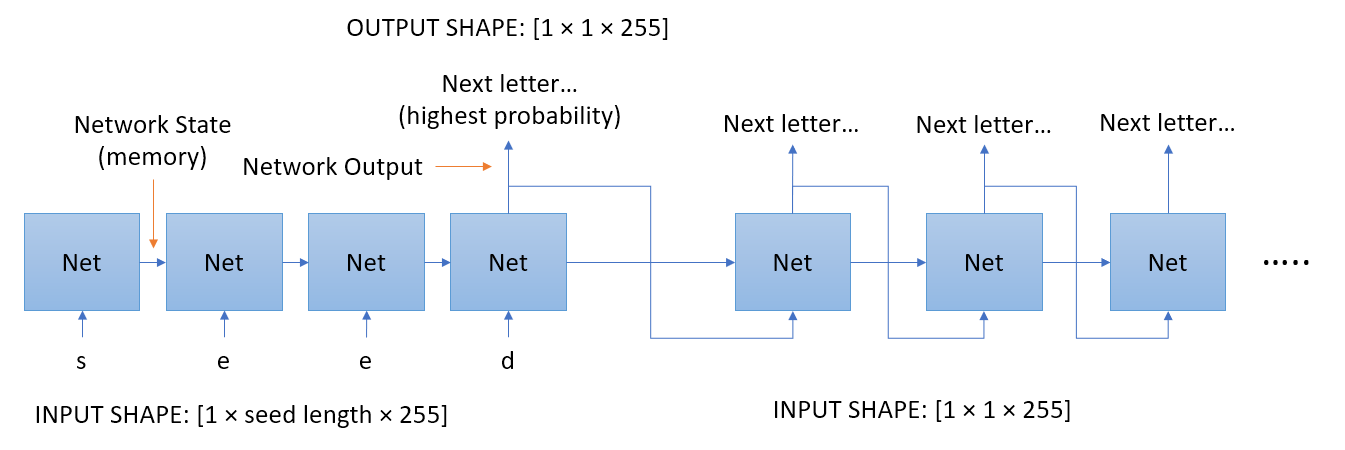

Notes: 

*   Prediction is letter-by-letter
*   Retrieve and set the initial network state (after the seed)
*   Stop if we reach a certain amount of characters in the same line (this may happen if the net never predicts newline character) or if we reach 14 lines (i.e., number of lines in sonnets)
*   Batch size always needed, even if a single sample is provided.



## Define the test transform

Character-level encoding -> One-hot encoding -> To tensor

(No need for random crop)

In [18]:
test_transform = transforms.Compose([EncodeText(), OneHotEncoder(alphabet_len), ToTensor()])

## Sonnet seed

Encode the seed to have a proper input for the network

In [19]:
sonnet_seed = 'thi' # TODO: change the input to see the outputs

# Prepare input
seed_input = test_transform(sonnet_seed)
seed_input = seed_input.to(device)

# Add batch axis (this is required to match the input shape supported by the network)
print(seed_input.shape)
seed_input = seed_input.unsqueeze(0)
print(seed_input.shape)

torch.Size([3, 255])
torch.Size([1, 3, 255])


Evaluate the initial state of the network (LSTM state after the elaboration of the seed text) and the next letter (letter with the highest output probability).

In [20]:
### Find initial state of the RNN
with torch.no_grad():
    # Forward pass
    net_out, initial_net_state = net(seed_input)
# Get the next most probable letter
next_char_encoded = net_out[:, -1, :].argmax().item()
# Decode character
next_char = decode_text([next_char_encoded])

# What we have
print(f"Seed text: {sonnet_seed}")
print(f"LSTM next input: {next_char} (encoded: {next_char_encoded})")
print(f"LSTM hidden state (shape): {initial_net_state[0].shape}") # 2 layers of the LSTM!
print(f"LSTM cell state (shape): {initial_net_state[1].shape}")

Seed text: thi
LSTM next input: s (encoded: 115)
LSTM hidden state (shape): torch.Size([2, 1, 128])
LSTM cell state (shape): torch.Size([2, 1, 128])


Provide the previous state and the last letter to the network iteratively.

Stop the generation when one of the following criteria are met:

- 14 lines generated
- 2000 total characters generated

SUGGESTION: Keep the dropout layer enabled to have some randomness in the output.

In [21]:
## Print seed and first predicted letter
print(sonnet_seed, end='')
print(next_char, end='')

### Set the initial network state (after the seed)
net_state = initial_net_state # it is the memory of the LSTM layers

### Generate sonnet
new_line_count = 0
tot_char_count = 0
while True:
  with torch.no_grad(): # No need to track the gradients
    # The new network input is the one hot encoding of the last chosen letter

    # Prepare input
    net_input = test_transform(next_char)
    net_input = net_input.to(device)
    net_input = net_input.unsqueeze(0)

    # Forward pass
    net_out, net_state = net(net_input, net_state)

    # Get the most probable letter index
    next_char_encoded = net_out.argmax().item()

    # Decode the letter
    next_char = decode_text([next_char_encoded])
    print(next_char, end='')

    # Count total letters
    tot_char_count += 1
    # Count new lines
    if next_char == '\n':
        new_line_count += 1
    # Break if 14 lines or 2000 letters
    if new_line_count == 14 or tot_char_count > 2000:
        break
  
    

this beauty's dearest in thee the stay
may not love that thee my love shall stay the world with the world with the world with the time,
and see when i have should that i have seen,
which heaven what i have seen,
which i be thought thee i see doth lies
the beauty of the world deares me thou art all the world do blessed than thee
as the world with the world may be some part.
then i am seem a sad a form from thee,
and every work watery brow,
for the bloods of the beauty of the world may be thoughts my bad,
then i have seen so my best be than the world may be thou art the stars of the stars,
and all the world with the world with the stars the stard of measured to the strong of thee:
then thou art the substance should be thy shadow thee to me the world despise
than the stard of my sightless eyes and the subjects the summer's love thee my love should be their growest
